In [2]:
# ==== Imports ====
import os
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [3]:
# ==== Hyperparameters ====

IMAGE_SIZE = 32           # CIFAR-10 image size (32x32)
CHANNELS = 3              # RGB images
BATCH_SIZE = 128          # Typical mini-batch size
VALIDATION_SPLIT = 0.2    # Fraction of data for validation (optional)
EMBEDDING_DIM = 2         # Latent space dimension (z_dim = 2 for visualization)
EPOCHS = 10               # Number of training epochs (increase for better reconstructions)
BETA = 1.0                # β for β-VAE (try <1, =1, >1 in later steps)
LEARNING_RATE = 0.0005      # Learning rate for Adam optimizer

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
# ==== Utils ====
def display(images, n=10, size=(20, 3), cmap=None, as_type="float32", save_to=None):
    """
    Displays n sample images from a given batch or array.
    Works with:
        - torch.Tensor or numpy.ndarray
        - RGB or grayscale images
    """
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    # Normalize if values are outside [0,1]
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    # Adjust grayscale shape [N,1,H,W] → [N,H,W]
    if images.ndim == 4 and images.shape[1] == 1:
        images = images.squeeze(1)
    # Adjust color shape [N,3,H,W] → [N,H,W,3]
    elif images.ndim == 4 and images.shape[1] == 3:
        images = np.transpose(images, (0, 2, 3, 1))

    plt.figure(figsize=size)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\n Saved to {save_to}")

    plt.show()


100%|██████████| 170M/170M [00:01<00:00, 93.4MB/s]


CIFAR-10 train tensor shape: torch.Size([50000, 3, 32, 32])
CIFAR-10 test  tensor shape: torch.Size([10000, 3, 32, 32])
Sample training images:


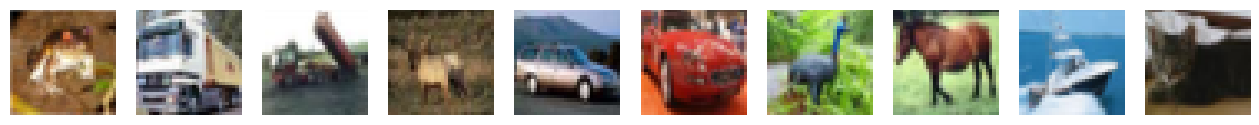

In [5]:
# ==== Data Preparation (CIFAR-10, using FashionMNIST as reference) ====
from torch.utils.data import TensorDataset

def preprocess_cifar(imgs: np.ndarray):
    """
    Normalize to [0,1] and convert to channel-first (N, 3, 32, 32) for PyTorch.
    CIFAR-10 comes as uint8 (N, 32, 32, 3).
    """
    imgs = imgs.astype("float32") / 255.0              # -> [0,1]
    imgs = np.transpose(imgs, (0, 3, 1, 2))            # NHWC -> NCHW
    return imgs

# Load raw datasets
train_dataset = datasets.CIFAR10(root="./data", train=True,  download=True)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True)

# To NumPy
x_train = train_dataset.data            # shape (50000, 32, 32, 3), uint8
y_train = np.array(train_dataset.targets)
x_test  = test_dataset.data
y_test  = np.array(test_dataset.targets)

# Preprocess
x_train = preprocess_cifar(x_train)     # -> (N, 3, 32, 32), float32 in [0,1]
x_test  = preprocess_cifar(x_test)

# To tensors
x_train_tensor = torch.from_numpy(x_train)        # float32
x_test_tensor  = torch.from_numpy(x_test)         # float32
y_test_tensor  = torch.from_numpy(y_test).long()  # optional

# Autoencoder target = input
train_loader = DataLoader(
    TensorDataset(x_train_tensor, x_train_tensor),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_loader = DataLoader(
    TensorDataset(x_test_tensor, x_test_tensor),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Quick peek
print("CIFAR-10 train tensor shape:", x_train_tensor.shape)
print("CIFAR-10 test  tensor shape:", x_test_tensor.shape)
print("Sample training images:")
display(x_train[:10], n=10, size=(16, 2.2), cmap=None)


In [6]:
# ==== Model Architecture (CIFAR-10) ====
class Encoder(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super().__init__()
        # Input: (N, 3, 32, 32)
        self.conv1 = nn.Conv2d(3,   32, kernel_size=3, stride=2, padding=1)  # -> (N, 32, 16, 16)
        self.conv2 = nn.Conv2d(32,  64, kernel_size=3, stride=2, padding=1)  # -> (N, 64, 8, 8)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # -> (N, 128, 4, 4)

        self.flatten_size = 128 * 4 * 4
        self.fc_mean    = nn.Linear(self.flatten_size, embedding_dim)
        self.fc_log_var = nn.Linear(self.flatten_size, embedding_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        z_mean    = self.fc_mean(x)
        z_log_var = self.fc_log_var(x)
        return z_mean, z_log_var

    def sample(self, z_mean, z_log_var):
        """Reparameterization trick"""
        eps = torch.randn_like(z_mean)
        z   = z_mean + torch.exp(0.5 * z_log_var) * eps
        return z


class Decoder(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, 128 * 4 * 4)
        # Mirror the encoder with transposed convs
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)  # -> 8x8
        self.deconv2 = nn.ConvTranspose2d(64,  32, kernel_size=3, stride=2, padding=1, output_padding=1)  # -> 16x16
        self.deconv3 = nn.ConvTranspose2d(32,   3, kernel_size=3, stride=2, padding=1, output_padding=1)  # -> 32x32

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 128, 4, 4)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  # keep outputs in [0,1] for BCE
        return x


class VAE(nn.Module):
    def __init__(self, embedding_dim=EMBEDDING_DIM):
        super().__init__()
        self.encoder = Encoder(embedding_dim)
        self.decoder = Decoder(embedding_dim)

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = self.encoder.sample(z_mean, z_log_var)
        x_hat = self.decoder(z)
        return z_mean, z_log_var, x_hat

    def compute_loss(self, x, x_hat, z_mean, z_log_var, beta=None):
        """
        Reconstruction: BCE summed over pixels per sample, then averaged over batch.
        KL: standard closed-form for N(μ, σ^2) vs N(0, I).
        Total loss = recon + β * KL  (β defaults to global BETA).
        """
        if beta is None:
            beta = BETA

        # Reconstruction loss
        recon = F.binary_cross_entropy(x_hat, x, reduction='none')
        recon = recon.view(recon.size(0), -1).sum(dim=1).mean()

        # KL divergence
        kl = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1).mean()

        total = recon + beta * kl
        return total, recon, kl


In [7]:
# ==== Training (CIFAR-10) ====

# Instantiate model & optimizer
vae = VAE(embedding_dim=EMBEDDING_DIM).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE)

# Create directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./logs', exist_ok=True)

print("\nStarting training...")
best_train_loss = float('inf')

for epoch in range(EPOCHS):
    # -------- Training --------
    vae.train()
    train_loss = 0.0
    train_recon = 0.0
    train_kl = 0.0

    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device, non_blocking=True)

        optimizer.zero_grad()
        z_mean, z_log_var, x_hat = vae(x)
        loss, recon_loss, kl_loss = vae.compute_loss(x, x_hat, z_mean, z_log_var, beta=BETA)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon += recon_loss.item()
        train_kl   += kl_loss.item()

    n_train_batches = len(train_loader)
    train_loss /= n_train_batches
    train_recon /= n_train_batches
    train_kl   /= n_train_batches

    # -------- “Validation” on test set (inference only, but without no_grad as requested) --------
    vae.eval()
    val_loss = 0.0
    val_recon = 0.0
    val_kl = 0.0

    for x, _ in test_loader:
        x = x.to(device, non_blocking=True)
        z_mean, z_log_var, x_hat = vae(x)
        loss, recon_loss, kl_loss = vae.compute_loss(x, x_hat, z_mean, z_log_var, beta=BETA)
        val_loss += loss.item()
        val_recon += recon_loss.item()
        val_kl   += kl_loss.item()

    n_val_batches = len(test_loader)
    val_loss /= n_val_batches
    val_recon /= n_val_batches
    val_kl   /= n_val_batches

    # -------- Logs --------
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train - Loss: {train_loss:.4f}, Recon: {train_recon:.4f}, KL: {train_kl:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Recon: {val_recon:.4f}, KL: {val_kl:.4f}")

    # -------- Save best checkpoint by training loss --------
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        torch.save({
            'epoch': epoch + 1,
            'vae_state_dict': vae.state_dict(),
            'encoder_state_dict': vae.encoder.state_dict(),
            'decoder_state_dict': vae.decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, './models/checkpoint_best_train.pth')

# -------- Save final models --------
torch.save(vae.state_dict(), './models/vae_final.pth')
torch.save(vae.encoder.state_dict(), './models/encoder_final.pth')
torch.save(vae.decoder.state_dict(), './models/decoder_final.pth')
print("\nModels saved: ./models/vae_final.pth, encoder_final.pth, decoder_final.pth")



Starting training...
Epoch 1/10
  Train - Loss: 1988.9797, Recon: 1984.0611, KL: 4.9186
  Val   - Loss: 1960.4125, Recon: 1955.2547, KL: 5.1578
Epoch 2/10
  Train - Loss: 1956.7881, Recon: 1951.6269, KL: 5.1612
  Val   - Loss: 1958.9266, Recon: 1953.8557, KL: 5.0708
Epoch 3/10
  Train - Loss: 1956.0595, Recon: 1950.9001, KL: 5.1594
  Val   - Loss: 1958.5821, Recon: 1953.3224, KL: 5.2598
Epoch 4/10
  Train - Loss: 1955.6281, Recon: 1950.4661, KL: 5.1619
  Val   - Loss: 1958.3872, Recon: 1953.3983, KL: 4.9889
Epoch 5/10
  Train - Loss: 1955.2661, Recon: 1950.1082, KL: 5.1580
  Val   - Loss: 1958.5526, Recon: 1953.3737, KL: 5.1789
Epoch 6/10
  Train - Loss: 1955.1455, Recon: 1949.9806, KL: 5.1648
  Val   - Loss: 1957.9612, Recon: 1952.8742, KL: 5.0870
Epoch 7/10
  Train - Loss: 1954.9932, Recon: 1949.8196, KL: 5.1735
  Val   - Loss: 1957.8853, Recon: 1952.7469, KL: 5.1383
Epoch 8/10
  Train - Loss: 1954.8618, Recon: 1949.6845, KL: 5.1773
  Val   - Loss: 1957.9803, Recon: 1952.9598, KL: 5


Testing Reconstruction
Example real CIFAR-10 images


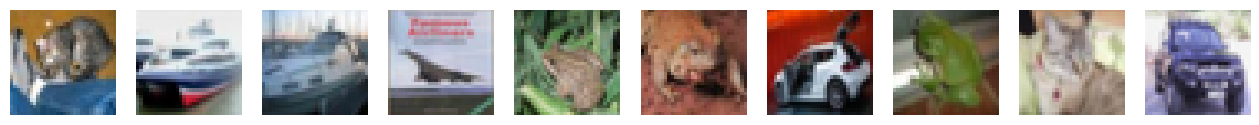

Reconstructions


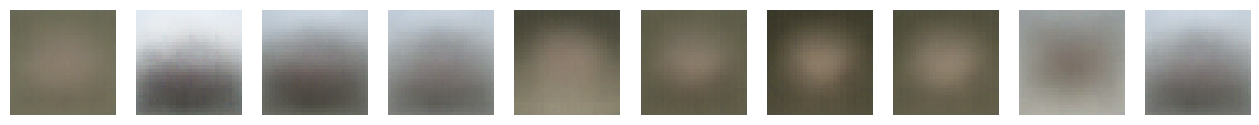

In [8]:
# ==== Reconstruction ====
print("\n" + "="*50)
print("Testing Reconstruction")
print("="*50)

n_to_predict = 5000
n_to_predict = min(n_to_predict, x_test_tensor.size(0))

example_images = x_test_tensor[:n_to_predict].to(device)   # (N, 3, 32, 32)
example_labels = y_test[:n_to_predict]                     # optional, not used

vae.eval()
z_mean, z_log_var, reconstructions = vae(example_images)

print("Example real CIFAR-10 images")
display(example_images[:10], n=10, size=(16, 2.2), cmap=None)

print("Reconstructions")
display(reconstructions[:10], n=10, size=(16, 2.2), cmap=None)



Encoding Images
Example embeddings:
[[-0.6130611  -0.23740745]
 [ 2.0121822  -0.50040656]
 [ 1.0592163  -0.84910667]
 [ 1.1869504  -0.12608333]
 [-0.978248    0.3537591 ]
 [-0.62954825 -0.65793455]
 [-1.2331542  -0.91267985]
 [-0.8625465  -0.57017094]
 [ 0.22756301  1.0568286 ]
 [ 1.2477928  -0.1260373 ]]


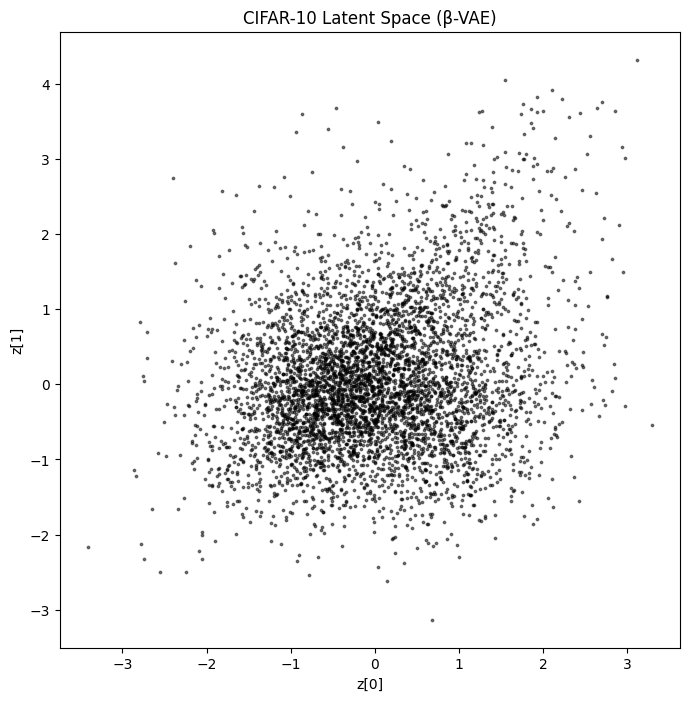

In [9]:
print("\n" + "="*50)
print("Encoding Images")
print("="*50)

example_images = x_test_tensor[:5000].to(device)

vae.eval()
z_mean, z_log_var = vae.encoder(example_images)
z = vae.encoder.sample(z_mean, z_log_var)

# Detach before converting to numpy
z = z.detach().cpu().numpy()
z_mean = z_mean.detach().cpu().numpy()

print("Example embeddings:")
print(z[:10])

# 2-D latent scatter
plt.figure(figsize=(8, 8))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.title("CIFAR-10 Latent Space (β-VAE)")
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


Generating New Images


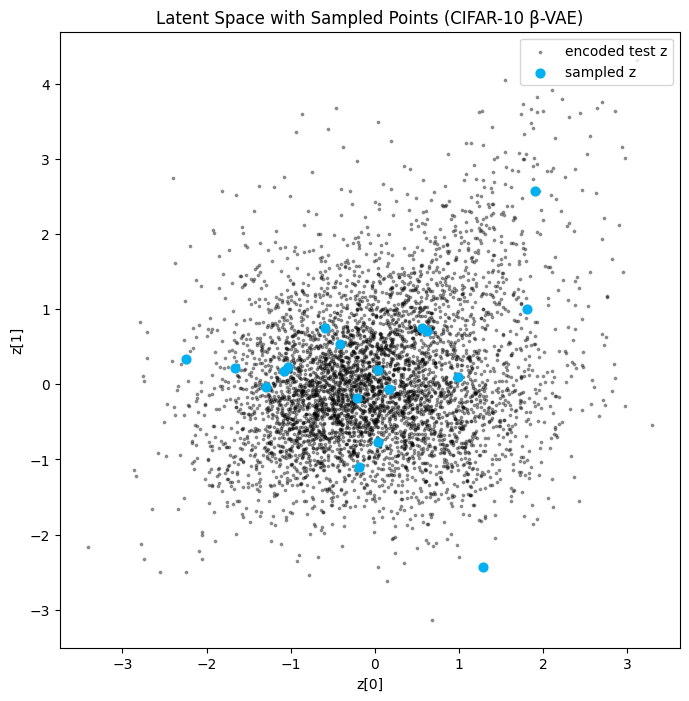

Generated images from sampled z:


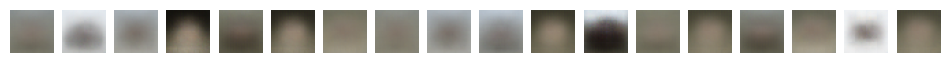

In [10]:
# ==== Generation (CIFAR-10) ====
print("\n" + "="*50)
print("Generating New Images")
print("="*50)

# Grid of latent samples
grid_width, grid_height = (6, 3)
n_gen = grid_width * grid_height

# Sample z ~ N(0, I) in 2D latent space
z_sample = torch.randn(n_gen, EMBEDDING_DIM, device=device, dtype=torch.float32)

# Decode to images in [0,1], shape (N, 3, 32, 32)
vae.eval()
gen = vae.decoder(z_sample)                 # tensor on device
gen_cpu = gen.detach().cpu()                # safe for plotting

# If you already ran the Embedding step, 'z' exists.
# If not, compute a quick embedding cloud for context.
try:
    _ = z  # check existence from earlier step
    z_plot = z
except NameError:
    example_images = x_test_tensor[:5000].to(device)
    z_mean_tmp, z_log_var_tmp = vae.encoder(example_images)
    z_tmp = vae.encoder.sample(z_mean_tmp, z_log_var_tmp)
    z_plot = z_tmp.detach().cpu().numpy()

# Also move sampled z to numpy for the scatter
z_sample_np = z_sample.detach().cpu().numpy()

# --- Visualize latent space with sampled points overlay ---
plt.figure(figsize=(8, 8))
plt.scatter(z_plot[:, 0], z_plot[:, 1], c="black", alpha=0.35, s=3, label="encoded test z")
plt.scatter(z_sample_np[:, 0], z_sample_np[:, 1], c="#00B0F0", alpha=1.0, s=40, label="sampled z")
plt.title("Latent Space with Sampled Points (CIFAR-10 β-VAE)")
plt.xlabel("z[0]"); plt.ylabel("z[1]")
plt.legend(loc="upper right")
plt.show()

# --- Show generated images (RGB) ---
print("Generated images from sampled z:")
display(gen_cpu, n=n_gen, size=(2.0*grid_width, 2.0), cmap=None)



Exploring Latent Space


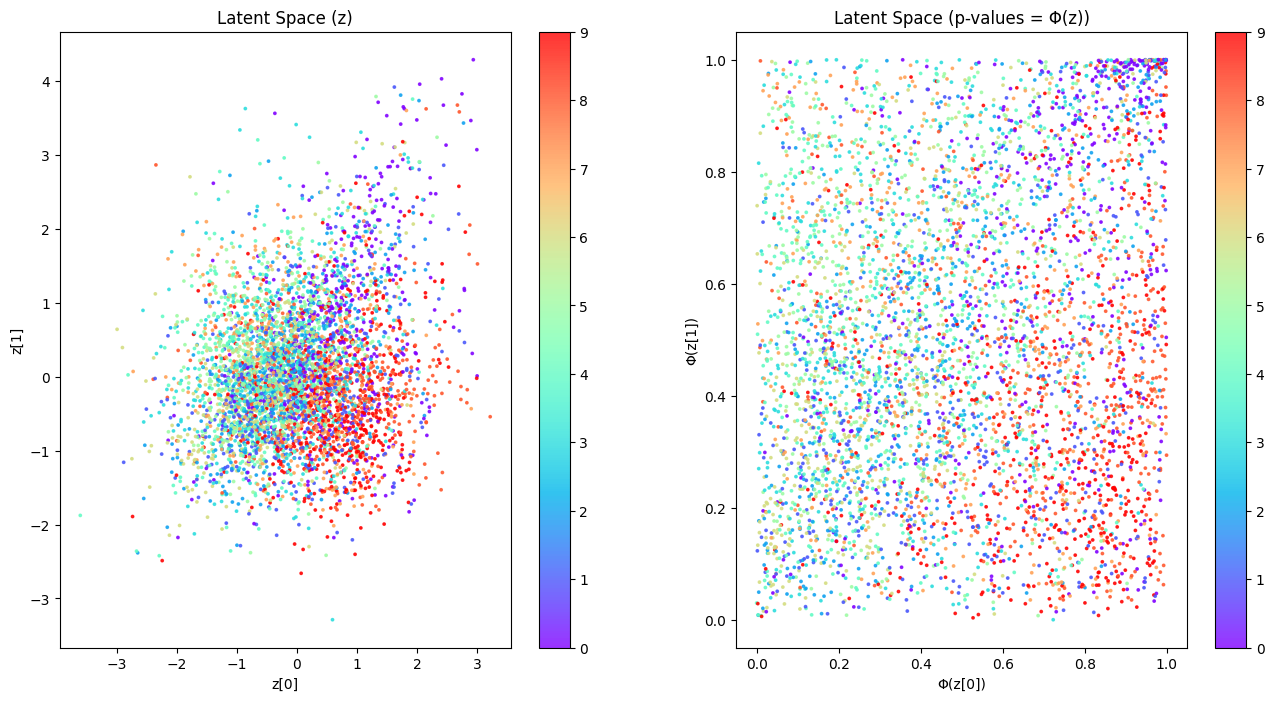


CIFAR-10 Labels:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck



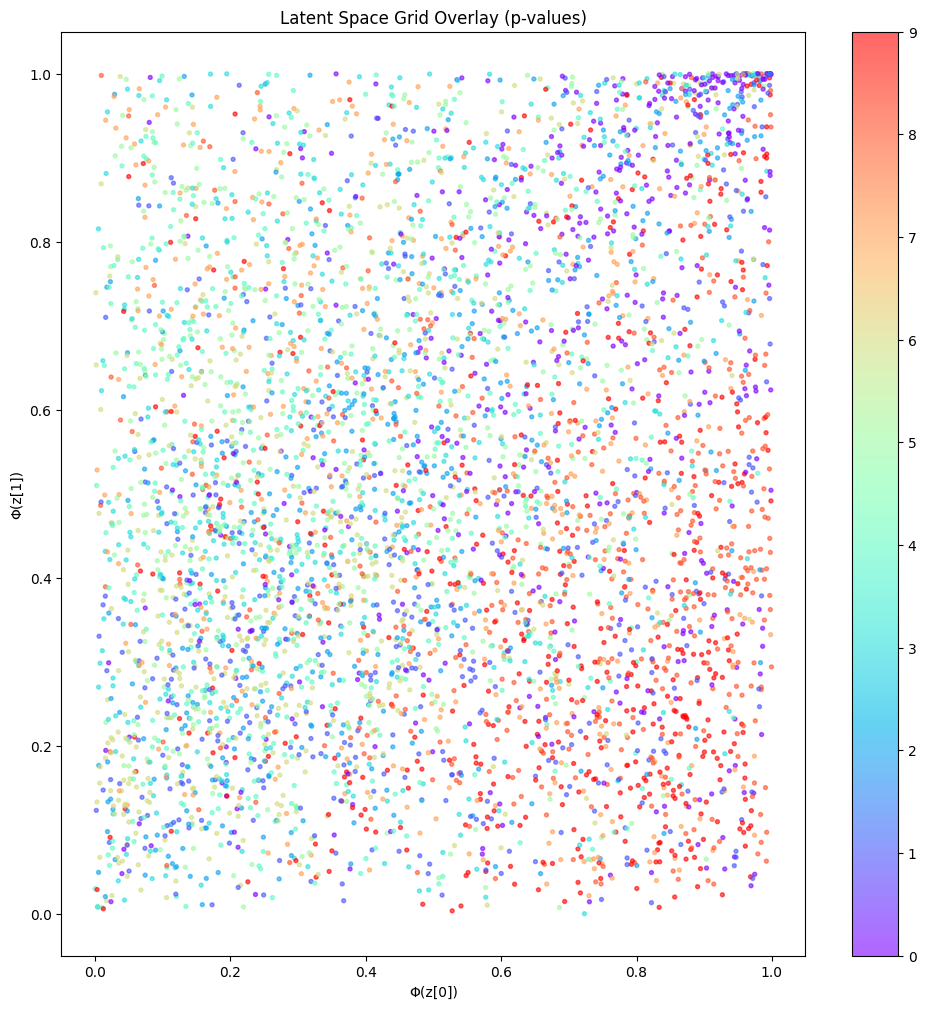

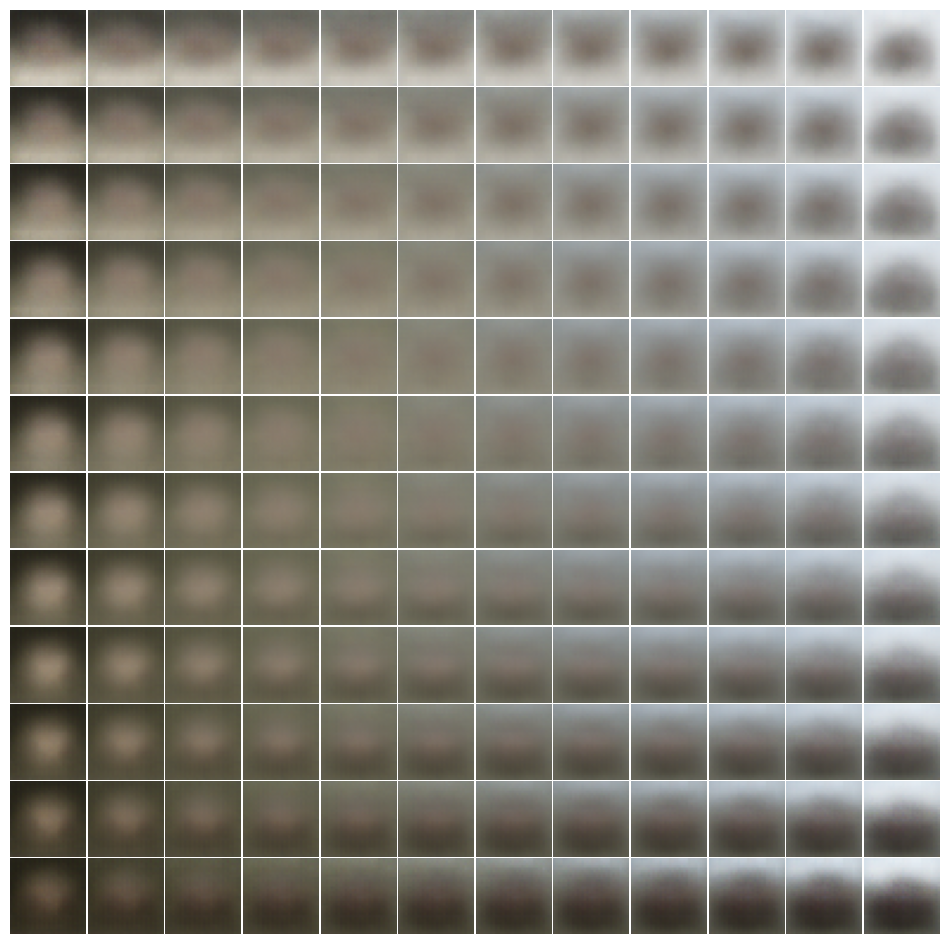


Done!


In [11]:
# ==== Explore Latent Space (CIFAR-10) ====
from scipy.stats import norm

print("\n" + "="*50)
print("Exploring Latent Space")
print("="*50)

# Use a consistent subset (same as earlier if you like)
n_embed = 5000
n_embed = min(n_embed, x_test_tensor.size(0))
example_images = x_test_tensor[:n_embed].to(device)
example_labels = y_test[:n_embed]  # numpy array of ints

# Encode → sample z
vae.eval()
z_mean, z_log_var = vae.encoder(example_images)
z = vae.encoder.sample(z_mean, z_log_var)

# To numpy for plotting
z_np = z.detach().cpu().numpy()

# Also compute p-values (Φ(z)) for a probability-space view
p_np = norm.cdf(z_np)

# ---- Color by CIFAR-10 label ----
plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 2, 1)
sc1 = ax.scatter(z_np[:, 0], z_np[:, 1], c=example_labels, cmap="rainbow", alpha=0.8, s=3)
plt.colorbar(sc1, ax=ax)
ax.set_title("Latent Space (z)")
ax.set_xlabel("z[0]"); ax.set_ylabel("z[1]")

ax = plt.subplot(1, 2, 2)
sc2 = ax.scatter(p_np[:, 0], p_np[:, 1], c=example_labels, cmap="rainbow", alpha=0.8, s=3)
plt.colorbar(sc2, ax=ax)
ax.set_title("Latent Space (p-values = Φ(z))")
ax.set_xlabel("Φ(z[0])"); ax.set_ylabel("Φ(z[1])")
plt.show()

print("""
CIFAR-10 Labels:
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
""")

# ---- Grid visualization over latent space using quantiles ----
figsize = 12
grid_size = 12  # assignment asks 12x12

# Show label-colored scatter in p-space as the background
plt.figure(figsize=(figsize, figsize))
plt.scatter(p_np[:, 0], p_np[:, 1], c=example_labels, cmap="rainbow", alpha=0.6, s=8)
plt.colorbar()
plt.title("Latent Space Grid Overlay (p-values)")
plt.xlabel("Φ(z[0])"); plt.ylabel("Φ(z[1])")
plt.show()

# Generate a uniform grid in probability space → map back via Φ^{-1} (norm.ppf)
xs = norm.ppf(np.linspace(0.05, 0.95, grid_size))
ys = norm.ppf(np.linspace(0.95, 0.05, grid_size))  # top→bottom visual sweep
xv, yv = np.meshgrid(xs, ys)
grid = np.stack([xv.flatten(), yv.flatten()], axis=1).astype(np.float32)  # (grid_size^2, 2)

# Decode grid points
grid_tensor = torch.from_numpy(grid).to(device)
gen_grid = vae.decoder(grid_tensor)                 # (N, 3, 32, 32) in [0,1]
gen_grid_np = gen_grid.detach().cpu().numpy()

# ---- Show decoded grid as images ----
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.02, wspace=0.02)

for i in range(grid_size * grid_size):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    img = np.transpose(gen_grid_np[i], (1, 2, 0))   # CHW → HWC
    ax.imshow(img)

plt.show()

print("\nDone!")



=== β-sweep training ===
β=0.5: test_rec=1952.0, test_KL=5.787, KL/dim=2.893, score=3.8453
β=1.0: test_rec=1952.4, test_KL=5.254, KL/dim=2.627, score=3.5792
β=2.0: test_rec=1954.2, test_KL=4.370, KL/dim=2.185, score=3.1392
β=4.0: test_rec=1955.9, test_KL=3.682, KL/dim=1.841, score=2.7968
β=6.0: test_rec=1957.7, test_KL=3.322, KL/dim=1.661, score=2.6190

=== Selected β for interpretability ===
β* = 6.0  |  KL/dim=1.661  |  recon=1957.7


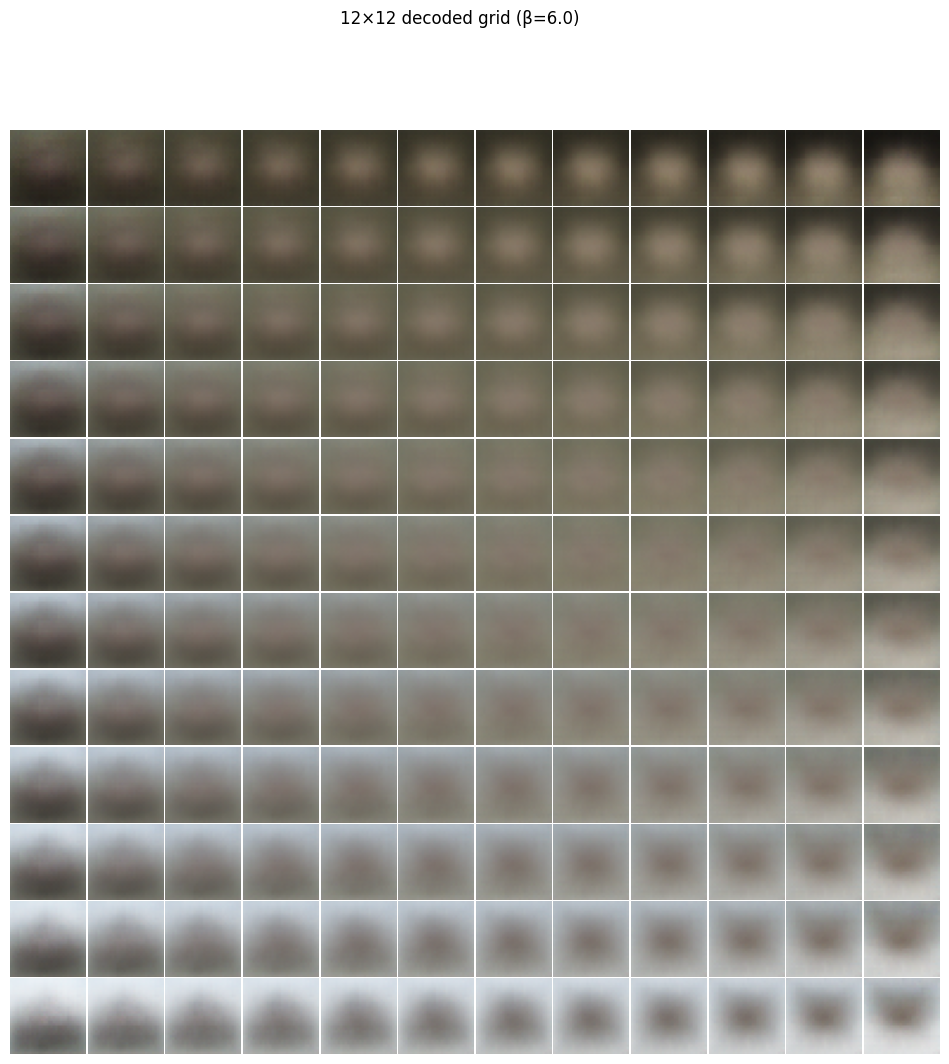

In [12]:
# ==== (b) β-sweep + select optimal β + 12×12 grid (CIFAR-10) ====
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.stats import norm

beta_values   = [0.5, 1.0, 2.0, 4.0, 6.0]         # β < 1, = 1, > 1
sweep_epochs  = max(8, EPOCHS // 3)               # quick passes; increase for stronger results
lambda_recon  = 1e-3                              # weight for recon in the selection heuristic

def train_one_epoch_beta(model, loader, opt, beta):
    model.train()
    total, rec_total, kl_total = 0.0, 0.0, 0.0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        opt.zero_grad()
        z_mu, z_logvar, x_hat = model(x)
        loss, rec, kl = model.compute_loss(x, x_hat, z_mu, z_logvar, beta=beta)
        loss.backward()
        opt.step()
        total += loss.item(); rec_total += rec.item(); kl_total += kl.item()
    n = len(loader)
    return total/n, rec_total/n, kl_total/n

def evaluate_beta(model, loader, beta):
    model.eval()
    total, rec_total, kl_total = 0.0, 0.0, 0.0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        z_mu, z_logvar, x_hat = model(x)
        loss, rec, kl = model.compute_loss(x, x_hat, z_mu, z_logvar, beta=beta)
        total += loss.item(); rec_total += rec.item(); kl_total += kl.item()
    n = len(loader)
    return total/n, rec_total/n, kl_total/n

def render_grid_for(model, grid_size=12, title="12×12 decoded grid"):
    xs = norm.ppf(np.linspace(0.05, 0.95, grid_size))
    ys = norm.ppf(np.linspace(0.95, 0.05, grid_size))
    xv, yv = np.meshgrid(xs, ys)
    grid = np.stack([xv.flatten(), yv.flatten()], axis=1).astype(np.float32)  # (grid^2, 2)
    z = torch.from_numpy(grid).to(device)
    imgs = model.decoder(z).detach().cpu().numpy()  # (N,3,32,32) in [0,1]
    fig = plt.figure(figsize=(12, 12)); fig.subplots_adjust(hspace=0.02, wspace=0.02)
    for i in range(grid_size * grid_size):
        ax = fig.add_subplot(grid_size, grid_size, i + 1); ax.axis("off")
        ax.imshow(np.transpose(imgs[i], (1, 2, 0)))
    plt.suptitle(title); plt.show()

results = []
models  = {}

print("\n=== β-sweep training ===")
for beta in beta_values:
    vae_tmp = VAE(embedding_dim=EMBEDDING_DIM).to(device)
    opt = torch.optim.Adam(vae_tmp.parameters(), lr=LEARNING_RATE)

    for ep in range(1, sweep_epochs + 1):
        tr_loss, tr_rec, tr_kl = train_one_epoch_beta(vae_tmp, train_loader, opt, beta)

    te_loss, te_rec, te_kl = evaluate_beta(vae_tmp, test_loader, beta)
    kl_per_dim = te_kl / EMBEDDING_DIM
    score = abs(kl_per_dim - 1.0) + lambda_recon * te_rec   # interpretability-friendly proxy

    results.append({
        "beta": beta, "test_loss": te_loss, "test_rec": te_rec,
        "test_kl": te_kl, "kl_per_dim": kl_per_dim, "score": score
    })
    models[beta] = vae_tmp
    print(f"β={beta:>3}: test_rec={te_rec:.1f}, test_KL={te_kl:.3f}, KL/dim={kl_per_dim:.3f}, score={score:.4f}")

# Pick optimal β (lowest score)
best = min(results, key=lambda r: r["score"])
best_beta = best["beta"]
vae_best  = models[best_beta]

print("\n=== Selected β for interpretability ===")
print(f"β* = {best_beta}  |  KL/dim={best['kl_per_dim']:.3f}  |  recon={best['test_rec']:.1f}")

# Render required 12×12 grid for the chosen β
render_grid_for(vae_best, grid_size=12, title=f"12×12 decoded grid (β={best_beta})")



=== (c) Training with over-regularized β=8.0 ===
Epoch 01 | train: loss 2010.4 (rec 1990.1, KL 2.545) | test: loss 1988.0 (rec 1964.4, KL 2.943)
Epoch 02 | train: loss 1983.5 (rec 1959.3, KL 3.026) | test: loss 1985.6 (rec 1961.8, KL 2.985)
Epoch 03 | train: loss 1982.7 (rec 1958.4, KL 3.029) | test: loss 1985.0 (rec 1961.5, KL 2.943)
Epoch 04 | train: loss 1982.4 (rec 1958.1, KL 3.032) | test: loss 1984.6 (rec 1960.1, KL 3.055)
Epoch 05 | train: loss 1982.1 (rec 1957.8, KL 3.032) | test: loss 1984.9 (rec 1961.9, KL 2.876)
Epoch 06 | train: loss 1981.8 (rec 1957.6, KL 3.028) | test: loss 1984.9 (rec 1961.1, KL 2.980)
Epoch 07 | train: loss 1981.9 (rec 1957.7, KL 3.025) | test: loss 1984.5 (rec 1960.6, KL 2.980)
Epoch 08 | train: loss 1981.5 (rec 1957.4, KL 3.017) | test: loss 1984.3 (rec 1959.3, KL 3.128)

Degraded reconstructions with high β (top: originals, bottom: recon):


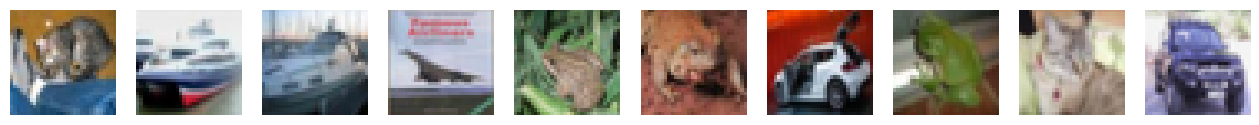

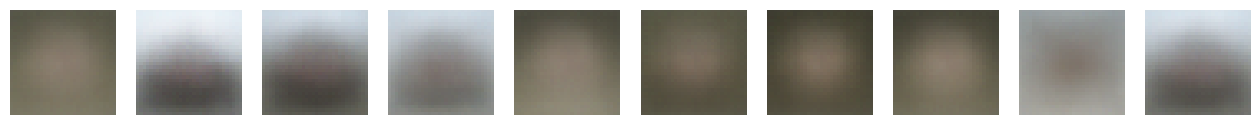


10 random generations with over-regularized β=8.0:


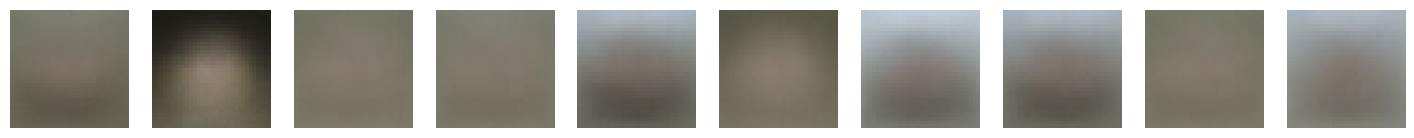

In [13]:
# ==== (c) Over-regularized β → degraded recon; show 10 generations ====

bad_beta = 8.0
epochs_bad = max(8, EPOCHS // 3)  # quick demo;

# Helper functions (reuse if already defined)
def train_one_epoch_beta(model, loader, opt, beta):
    model.train()
    total = rec_total = kl_total = 0.0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        opt.zero_grad()
        z_mu, z_logvar, x_hat = model(x)
        loss, rec, kl = model.compute_loss(x, x_hat, z_mu, z_logvar, beta=beta)
        loss.backward()
        opt.step()
        total += loss.item(); rec_total += rec.item(); kl_total += kl.item()
    n = len(loader)
    return total/n, rec_total/n, kl_total/n

def evaluate_beta(model, loader, beta):
    model.eval()
    total = rec_total = kl_total = 0.0
    for x, _ in loader:
        x = x.to(device, non_blocking=True)
        z_mu, z_logvar, x_hat = model(x)
        loss, rec, kl = model.compute_loss(x, x_hat, z_mu, z_logvar, beta=beta)
        total += loss.item(); rec_total += rec.item(); kl_total += kl.item()
    n = len(loader)
    return total/n, rec_total/n, kl_total/n

# Train a fresh model with "bad" β
vae_bad = VAE(embedding_dim=EMBEDDING_DIM).to(device)
opt_bad = torch.optim.Adam(vae_bad.parameters(), lr=LEARNING_RATE)

print(f"\n=== (c) Training with over-regularized β={bad_beta} ===")
for ep in range(1, epochs_bad + 1):
    tr_loss, tr_rec, tr_kl = train_one_epoch_beta(vae_bad, train_loader, opt_bad, beta=bad_beta)
    te_loss, te_rec, te_kl = evaluate_beta(vae_bad, test_loader, beta=bad_beta)
    print(f"Epoch {ep:02d} | train: loss {tr_loss:.1f} (rec {tr_rec:.1f}, KL {tr_kl:.3f}) "
          f"| test: loss {te_loss:.1f} (rec {te_rec:.1f}, KL {te_kl:.3f})")

# quick look at recon degradation on first 10 test images
example_images = x_test_tensor[:10].to(device)
vae_bad.eval()
_, _, recon_bad = vae_bad(example_images)
print("\nDegraded reconstructions with high β (top: originals, bottom: recon):")
display(example_images.detach().cpu(), n=10, size=(16, 2.2), cmap=None)
display(recon_bad.detach().cpu(),     n=10, size=(16, 2.2), cmap=None)

# Generate 10 random images from the prior N(0, I) using the bad-β model
n_gen = 10
z = torch.randn(n_gen, EMBEDDING_DIM, device=device)
gen_imgs = vae_bad.decoder(z).detach().cpu()

print(f"\n10 random generations with over-regularized β={bad_beta}:")
display(gen_imgs, n=n_gen, size=(1.8*n_gen, 2.0), cmap=None)
